In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd

from sklearn.decomposition import PCA
from scipy import signal
from scipy.io import loadmat
from numpy.fft import fft, ifft
from scipy.signal import find_peaks
from scipy import linalg
from IPython.display import Audio


dietdata = loadmat('dietdata', squeeze_me = True)
eegdata = loadmat('eegdata', squeeze_me = True)
noisyspeech = loadmat('noisyspeech', squeeze_me = True)
SpikeSorting = loadmat('SpikeSorting', squeeze_me = True)


16384
1A: Filter order can be determined by finding the cuttoff frequency at the target cutoff of 30Hz outside of the desired filter frequency range. This was the sampling frequency divided by 30 to achieve the correct cutoff. 
1B: 0.09041197131574696 % Gain over 3030Hz and 2.26309283334504 % Gain under 40Hz. Therefore the filter is less than 10% at at and passed these frequencies


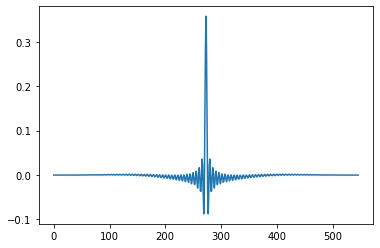

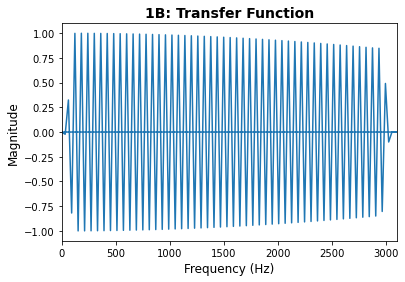

In [2]:
#1.a, 1.b

raw = (eegdata['raw']) #raw recording
fs = eegdata['fs'] #sample rate
clicks = eegdata['clicks'] # sample numbers of the raw recording where sound was started

lowfreq = 70 #Hz low frequency of the filter
highfreq = 3000 #Hz high frequency of the filter


boxlen = round(fs/30)+1 # width of window
cutoff = np.array([lowfreq,highfreq]) #creates array of cuttoff freq

h = signal.firwin(boxlen, cutoff, pass_zero='bandpass', fs=fs) #transfer function filter 
plt.figure()
plt.plot(h)
#print(fs)
hF = np.fft.fftfreq((h).shape[0]) * fs 
maghF = (np.fft.fft(h)).real

#print(boxlen)

plt.figure()
plt.plot(hF,maghF)
plt.title('1B: Transfer Function',fontweight='bold',fontsize=14)
plt.ylabel('Magnitude',fontsize=12)
plt.xlabel('Frequency (Hz)',fontsize=12)
plt.xlim(0,3100)


hFfind = hF[hF>0]
hfind = maghF[hF>0]
over3030Hz = abs(np.max(hfind[hFfind > 3030]))
under40Hz = abs(np.max(hfind[hFfind < 40])) 
print(fs)
print('1A: Filter order can be determined by finding the cuttoff frequency at the target cutoff of 30Hz outside of the desired filter frequency range. This was the sampling frequency divided by 30 to achieve the correct cutoff. ')
print('1B:', over3030Hz*100,'% Gain over 3030Hz and', under40Hz*100,'% Gain under 40Hz. Therefore the filter is less than 10% at at and passed these frequencies')


1C: Forward Backward Filter could be utilized in order to remove any delay that a window method would create. This can be dones since it is not a live data stream. Without a delay, accessing latency information on wave-I would be as easy as looking at the plot.


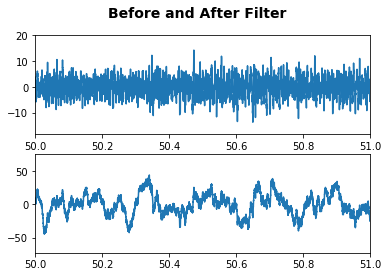

In [3]:
#1.c
time = np.arange(0,300,1/fs)

forwardbackwardfilt = signal.filtfilt(h,1,raw)


fig1, (plt1,plt2) = plt.subplots(2)
plt1.plot(time,forwardbackwardfilt) #bandpass filter applied to raw data
plt1.set(xlim=[50,51])
plt2.plot(time, raw)
plt2.set(xlim=[50,51])
plt.suptitle('Before and After Filter',fontweight='bold',fontsize=14)

print('1C: Forward Backward Filter could be utilized in order to remove any delay that a window method would create. This can be dones since it is not a live data stream. Without a delay, accessing latency information on wave-I would be as easy as looking at the plot.')

In [4]:
#1.d and 1.e
epochs = []
ct = 0
datalength = np.arange(0,len(raw))

for i in datalength:
    if i == clicks[ct]:
        epochs.append(forwardbackwardfilt[round(i - .002*fs):round(i+ .01*fs)])
        ct = ct + 1
    if ct == 1000:
        break


ClickAvg = np.shape(epochs)[1]
ABR = np.zeros(ClickAvg)
NewABR = np.zeros(ClickAvg)

ABR = np.average(epochs, axis = 0)
print('1E: The signal to noise ratio should be improved by 1000 in averaged data compared to raw data because the data was averaged from 1000 points')


1E: The signal to noise ratio should be improved by 1000 in averaged data compared to raw data because the data was averaged from 1000 points


Text(0.5, 1.0, '1F: ABR Averaged Estimate')

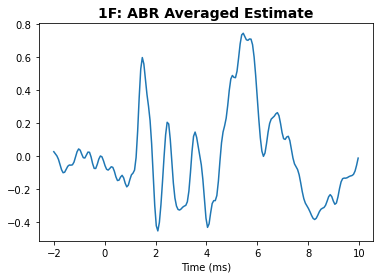

In [5]:
#1.f

timeABR = np.arange(-0.002, 0.010, 1/fs) * 1000

plt.figure()
plt.plot(timeABR,ABR)
plt.xlabel('Time (ms)')
plt.title('1F: ABR Averaged Estimate',fontweight='bold',fontsize=14)




In [6]:
#1.g

peaks, properties = find_peaks(ABR, distance=round(0.002*fs))
TimeOfPeaks = timeABR[peaks]
print('1G: A Red Flag Peak occurs at:',TimeOfPeaks[2],'ms, but a normal peak occurs at', TimeOfPeaks[1],'ms as well')

1G: A Red Flag Peak occurs at: 5.4462890625 ms, but a normal peak occurs at 1.47900390625 ms as well


In [7]:
#2
def activefilter (x, nref, p): # array input x, ref node, filter length p
    #print('test print to make sure function works')
    
    A = linalg.toeplitz(nref[p:],nref[:p][::-1])
    #print(A.shape)
    #print(linalg.pinv(A).shape)
    xsub = x[p:]
    h = linalg.lstsq(A, xsub)[0] #used this function as I was running out of RAM on my PC
    s_hat = x - signal.lfilter(h,1,nref)
    
    return(h, s_hat);

print('2A: look above for active filter code!')

2A: look above for active filter code!


2B: Active filtering appears to be working well at filtering out nearly all noise as seen in the very bottom plot


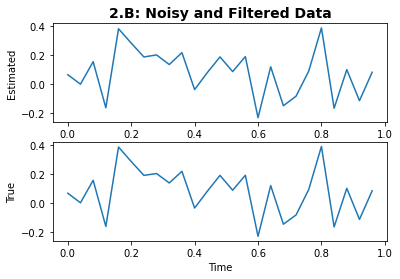

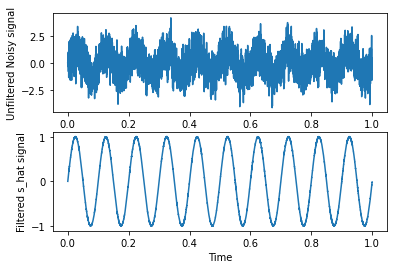

In [8]:
#2.b
signal_time = np.arange(0,1,1/8000) #0-1 sec sample at 10Hz
sample_signal = np.sin(2*np.pi*10*signal_time)

h_sample = np.random.normal(0,.2,25)
nref_sample = np.random.normal(0,1,sample_signal.size)

filterwhite = np.convolve(nref_sample,h_sample) #convoled white noise and sample
sampletest = []

for i in np.arange(0,sample_signal.size):
    sampletest.append(sample_signal[i] + filterwhite[i])
    
#print(len(sampletest))
h,s_hat = activefilter(sampletest,nref_sample,25)

h_time = np.arange(0,1,1/25)

fig2, (plt3,plt4) = plt.subplots(2)
plt3.plot(h_time, h_sample)
plt4.plot(h_time, h)
plt3.set_ylabel('Estimated')
plt4.set_ylabel('True')
plt4.set_xlabel('Time')
plt3.set_title('2.B: True and Estimated filters',fontweight='bold',fontsize=14)

fig3, (plt5,plt6) = plt.subplots(2)
plt5.plot(signal_time, sampletest)
plt6.plot(signal_time, s_hat)
plt5.set_ylabel('Unfiltered Noisy signal')
plt6.set_ylabel('Filtered s_hat signal')
plt6.set_xlabel('Time')
plt3.set_title('2.B: Noisy and Filtered Data',fontweight='bold',fontsize=14)

print('2B: Active filtering appears to be working well at filtering out nearly all noise as seen in the very bottom plot')

2C: I chose a filter order of 64 as the impulse function filled the filter length perfectly rather than compressing like orders 128 or 256 seen below.
2C: The signal is compressed at 256th order where as it fills the whole filter length at a 64th order.


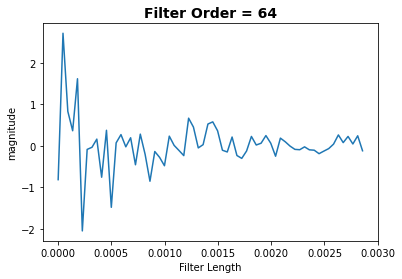

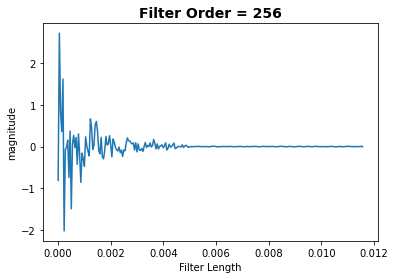

In [9]:
#2.c
x1 = noisyspeech['x']
nref1 = noisyspeech['nref']
fs = noisyspeech['fs']

s_hat = []
h = []
lengthfilter = []
FRange = [8,16,64,128,256] 
FilterOrders = len(FRange)

for i in range(0,FilterOrders): #need to create loop to compare all at once
    h,s_hat = activefilter(x1,nref1,FRange[i])
    lengthfilter.append(np.arange(0, FRange[i]/fs, 1/fs))

    if i == 2 or i == 4:
        plt.figure()
        plt.plot(lengthfilter[i],h)
        plt.title('Filter Order = {}' .format(FRange[i]),fontweight='bold',fontsize=14)
        plt.ylabel('magnitude')
        plt.xlabel('Filter Length')
    
#print(h)

Audio(data=x1, rate =fs) #plays unfiltered audio

print('2C: I chose a filter order of 64 as the impulse function filled the filter length perfectly rather than compressing like orders 128 or 256 seen below.')
print('2C: The signal is compressed at 256th order where as it fills the whole filter length at a 64th order.')

In [10]:
#2d
Audio(data=s_hat, rate = fs)
print('2D: The active filter does an incredible job at filtering out the noise of the traffic!')


2D: The active filter does an incredible job at filtering out the noise of the traffic!


In [11]:
#2e 

SubtractedNoise = x1 - nref1

Audio(data=SubtractedNoise, rate = fs) #signal - noise output

print('2E: A simple subtraction does an awful job at filtering out the noise as the noise has many frequencies overlapping the signal and with varying intensities. Therefore subtracting the noise also reduces the goal signal')

2E: A simple subtraction does an awful job at filtering out the noise as the noise has many frequencies overlapping the signal and with varying intensities. Therefore subtracting the noise also reduces the goal signal


In [12]:
#3
#exercise = noise = nref
#diet  = signal
#diet + exercise = input

weightloss = dietdata['weightloss']
exercise = dietdata['exercise']
year = np.arange(0,365)
subjects = np.arange(0,20)
#3a


#print('exercise',exercise)

avgweightloss = np.mean(weightloss)

print('3A: Average weightloss',avgweightloss, 'lbs')

3A: Average weightloss 8.2 lbs


3B: A Regression Filter Coefficient of 1 was chosen because the first element in h is the same as beta. Therefore n_hat is already equal to nref and beta = 1


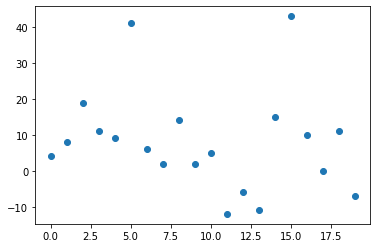

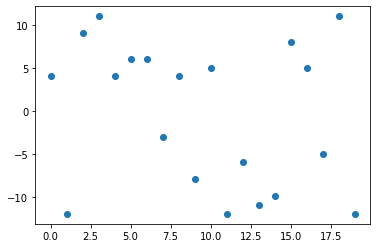

In [20]:
#3b

h=[]
s_hat = []

filterweight = np.convolve(exercise,weightloss) #convoled white noise and sample
DietWeightLoss = []

#for i in np.arange(0,weightloss.size):
#    DietWeightLoss.append(weightloss[i] - exercise[i])

h, s_hat = activefilter(weightloss,exercise,1)  #p = 1 because the first element in H is the same as beta. 


#print('s_hat',s_hat,)
#print('weightloss',weightloss)
#print('exercise',exercise)

avgs_hat = np.mean(s_hat)

print('3B: A Regression Filter Coefficient of 1 was chosen because the first element in h is the same as beta. Therefore n_hat is already equal to nref and beta = 1')

#plt.figure()
#plt.scatter(subjects,weightloss )
#plt.figure()
#plt.scatter(subjects,s_hat)



In [14]:
#3c
print('3C: Average weight loss after removing exercise value',avgs_hat, 'lbs. This indicates that exercise would be a main contributor to weight loss rather than the new diet')

3C: Average weight loss after removing exercise value -0.2891036033630371 lbs. This indicates that exercise would be a main contributor to weight loss rather than the new diet


Text(0.5, 0, 'Time')

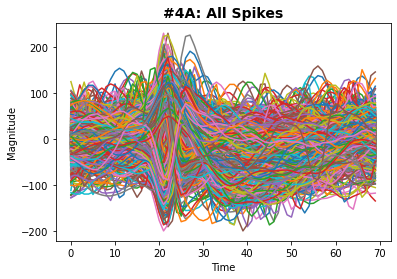

In [15]:
#4a
voltage = SpikeSorting['voltage']
spikes = SpikeSorting['spikes']

waveforms = []
samplestime = np.arange(0,70,1)
sampleswidth = np.arange(0,len(spikes),1)

for i in spikes:
    waveforms.append(voltage[i:i+70]) #time of spike 0 and 70 voltage points after

for i in range(0,len(spikes)):
    plt.plot(samplestime,waveforms[i])
plt.title('#4A: All Spikes',fontweight='bold',fontsize=14)
plt.ylabel('Magnitude')
plt.xlabel('Time')

In [16]:
#4b
WaveformAxes = np.array(waveforms).astype(np.double)

#print(WaveformsAxes)
covwaveform = np.cov(np.transpose(WaveformAxes))

(70, 70)
4C: Bright colors indicate high covariance intensity in occurance of spike location. Dark colors indicate uncorrelation of spikes afterwards.
Because a neuron Action Potential is not just a single spike, rather than a depolarization-hyperpolarization ripple, there are other correlated times of smaller spikes and times lacking spikes at all, these are depicted by the lighter hot and cold bands extending away from the original action potential bright spot 


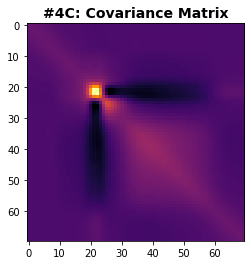

In [17]:
#4c
plt.imshow(covwaveform, cmap="inferno") 
plt.title('#4C: Covariance Matrix',fontweight='bold',fontsize=14)
print(covwaveform.shape)
#same spike location and uncorrelated after spikes
print('4C: Bright colors indicate high covariance intensity in occurance of spike location. Dark colors indicate uncorrelation of spikes afterwards.')
print('Because a neuron Action Potential is not just a single spike, rather than a depolarization-hyperpolarization ripple, there are other correlated times of smaller spikes and times lacking spikes at all, these are depicted by the lighter hot and cold bands extending away from the original action potential bright spot ')

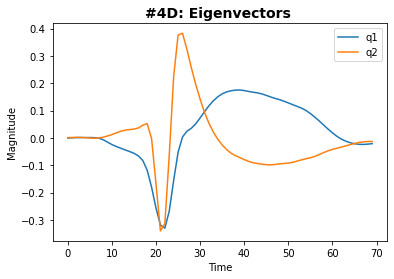

In [18]:
#4d
eigenValues, eigenVectors = np.linalg.eigh(covwaveform)
q1q2 = [eigenVectors[:, -1], eigenVectors[:,-2]]


plt.figure()
plt.plot(samplestime,q1q2[0], label = "q1")
plt.plot(samplestime,q1q2[1], label = "q2")
plt.title('#4D: Eigenvectors ',fontweight='bold',fontsize=14)
plt.ylabel('Magnitude')
plt.xlabel('Time')
plt.legend()

In [19]:
#4e
y1 = []
y2 = []

for i in sampleswidth:
    y1.append(np.dot(q1, WaveformAxes[i,:]))
    y2.append(np.dot(q2, WaveformAxes[i,:]))

ylength = np.arange(0,len(y1))

for i in ylength:
    plt.scatter(y1[i],y2[i])
    plt.xlabel('y1')
    plt.title('#4D: Eigenvectors ',fontweight='bold',fontsize=14)
    plt.ylabel('y2')
    


NameError: name 'q1' is not defined

In [ ]:
#4f

print('4F: 3 neurons are in the mix; each cluster represents a set of spikes given from a single neuron')

In [ ]:
#4g

#print(ylength)
firstcluster = [i for i in ylength if y1[i] > -100 and y1[i] <380 and y2[i] > 0 and y2[i] <350]
secondcluster = [i for i in ylength if y1[i] > -600 and y1[i] <-200 and y2[i] > 0 and y2[i] <250]
thirdcluster = [i for i in ylength if y1[i] > -300 and y1[i] <300 and y2[i] > -400 and y2[i] <0]


plt.figure()
for i in firstcluster:
    plt.plot(y1[i],y2[i], 'ko')
for i in secondcluster:
    plt.plot(y1[i],y2[i], 'ro')
for i in thirdcluster:
    plt.plot(y1[i],y2[i], 'go')
   
plt.title('#4G: Sorted Spike Clusters',fontweight='bold',fontsize=14)
plt.ylabel('y2')
plt.xlabel('y1')

In [ ]:
#4h
plt.figure()
for i in firstcluster:
    plt.plot(np.arange(0,70), waveforms[i])
plt.title('#4H: Cluster1 Full Spike Shapes',fontweight='bold',fontsize=14)
plt.ylabel('Magnitude')
plt.xlabel('Time')

print('4H: They are all homogenous with small variation and same general shape')

#plt.figure()
#for i in secondcluster:
#    plt.plot(np.arange(0,70), waveforms[i])
    
#plt.figure()
#for i in thirdcluster:
#    plt.plot(np.arange(0,70), waveforms[i])



In [ ]:
#4i

ak = []
bk = []

for i in firstcluster:
    ak.append(y1[i])
    bk.append(y2[i])
aMean = np.mean(ak)
bMean = np.mean(bk)

aqbq = aMean * q1 + bMean * q2

plt.figure()
for i in firstcluster:
    plt.plot(waveforms[i])
plt.plot(aqbq, 'k', linewidth = 10)
plt.title('#4I: Cluster1 Full Spike Shapes with aq1 + bq2 Traced',fontweight='bold',fontsize=14)
plt.ylabel('Magnitude')
plt.xlabel('Time')

print('#4I: Dimensionality reduction did work as the black line shows the mean spike for the neuron, thereby reducing the dimensions of all spikes to one spike')

In [ ]:
#4j

ak2 = []
bk2 = []

for i in secondcluster:
    ak2.append(y1[i])
    bk2.append(y2[i])
a2Mean = np.mean(ak2)
b2Mean = np.mean(bk2)

aqbq2 = a2Mean * q1 + b2Mean * q2

plt.figure()
for i in secondcluster:
    plt.plot(waveforms[i])
plt.plot(aqbq2, 'k', linewidth = 10)
plt.title('#4J: Cluster2 Full Spike Shapes with aq1 + bq2 Traced',fontweight='bold',fontsize=14)
plt.ylabel('Magnitude')
plt.xlabel('Time')

ak3 = []
bk3 = []

for i in thirdcluster:
    ak3.append(y1[i])
    bk3.append(y2[i])
a3Mean = np.mean(ak3)
b3Mean = np.mean(bk3)

aqbq3 = a3Mean * q1 + b3Mean * q2

plt.figure()
for i in thirdcluster:
    plt.plot(waveforms[i])
plt.plot(aqbq3, 'k', linewidth = 10)
plt.title('#4J: Cluster3 Full Spike Shapes with aq1 + bq2 Traced',fontweight='bold',fontsize=14)
plt.ylabel('Magnitude')
plt.xlabel('Time')


print('4J: Similarly to Cluster 1 in 4I, dimesnionality reduction effectively worked on the other two neurons.')